In [88]:
import os
import glob
import pydicom
import nibabel as nib
import pandas as pd
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from tqdm import tqdm

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from utils.dcm_utils import *
from utils.nii_utils import *
from utils.train_utils import *
from utils.xray_utils import *

from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop
import torchvision.transforms.functional as TF

In [5]:
DATA_DIR = "/media/longyi/SSD9701/"
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, "train_images")
XRAY_IMAGES_DIR = os.path.join(DATA_DIR, "xray_images")

In [14]:
xray_df = pd.read_csv(os.path.join(DATA_DIR, 'meta_xray.csv'))
xray_df = xray_df.set_index('UID')
xray_df.head()

,direction,z_spacing,pixel_spacing,aspect,width,height
UID,,,,,,
1.2.826.0.1.3680043.10005,0,0.625,0.298828,2.091504,512,512
1.2.826.0.1.3680043.10005,1,0.625,0.298828,2.091504,512,541
1.2.826.0.1.3680043.10005,2,0.625,0.298828,2.091504,512,541
1.2.826.0.1.3680043.10014,0,0.800,0.234000,3.418803,512,512
1.2.826.0.1.3680043.10014,1,0.800,0.234000,3.418803,512,882


In [138]:
dcm_df = pd.read_csv(os.path.join(DATA_DIR, 'meta_dcm_dataset.csv'))
dcm_df = dcm_df.set_index('StudyInstanceUID')
dcm_df.head()

,id,PatientID,InstanceNumber,Rows,Columns,SliceThickness,ImagePositionPatientX,ImagePositionPatientY,ImagePositionPatientZ,ImageOrientationPatientRowX,...,BitsStored,HighBit,PixelRepresentation,WindowCenter,WindowWidth,RescaleIntercept,RescaleSlope,SamplesPerPixel,PixelSpacingX,PixelSpacingY
StudyInstanceUID,,,,,,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.17625,176250012,17625,12,512,512,0.625,-104.9,-25.9,-36.480,1.0,...,16,15,1,400,2500,-1024,1.0,1,0.277344,0.277344
1.2.826.0.1.3680043.17625,176250210,17625,210,512,512,0.625,-104.9,-25.9,-160.230,1.0,...,16,15,1,400,2500,-1024,1.0,1,0.277344,0.277344
1.2.826.0.1.3680043.17625,176250120,17625,120,512,512,0.625,-104.9,-25.9,-103.980,1.0,...,16,15,1,400,2500,-1024,1.0,1,0.277344,0.277344
1.2.826.0.1.3680043.17625,176250208,17625,208,512,512,0.625,-104.9,-25.9,-158.980,1.0,...,16,15,1,400,2500,-1024,1.0,1,0.277344,0.277344
1.2.826.0.1.3680043.17625,176250141,17625,141,512,512,0.625,-104.9,-25.9,-117.105,1.0,...,16,15,1,400,2500,-1024,1.0,1,0.277344,0.277344


## Find coronal center

In [146]:
patient_id = "1.2.826.0.1.3680043.575"

In [147]:
patient_dcm_df = dcm_df.loc[patient_id].sort_values(by='InstanceNumber')
patient_dcm_df.head()

,id,PatientID,InstanceNumber,Rows,Columns,SliceThickness,ImagePositionPatientX,ImagePositionPatientY,ImagePositionPatientZ,ImageOrientationPatientRowX,...,BitsStored,HighBit,PixelRepresentation,WindowCenter,WindowWidth,RescaleIntercept,RescaleSlope,SamplesPerPixel,PixelSpacingX,PixelSpacingY
StudyInstanceUID,,,,,,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.575,5750001,575,1,512,512,0.8,-84.463158,96.199998,89.500000,1.0,...,12,11,0,800,2000,-1024,1.0,1,0.265625,0.265625
1.2.826.0.1.3680043.575,5750002,575,2,512,512,0.8,-84.463158,96.199998,89.900024,1.0,...,12,11,0,800,2000,-1024,1.0,1,0.265625,0.265625
1.2.826.0.1.3680043.575,5750003,575,3,512,512,0.8,-84.463158,96.199998,90.299988,1.0,...,12,11,0,800,2000,-1024,1.0,1,0.265625,0.265625
1.2.826.0.1.3680043.575,5750004,575,4,512,512,0.8,-84.463158,96.199998,90.700012,1.0,...,12,11,0,800,2000,-1024,1.0,1,0.265625,0.265625
1.2.826.0.1.3680043.575,5750005,575,5,512,512,0.8,-84.463158,96.199998,91.099976,1.0,...,12,11,0,800,2000,-1024,1.0,1,0.265625,0.265625


NameError: name 'coronal_center' is not defined

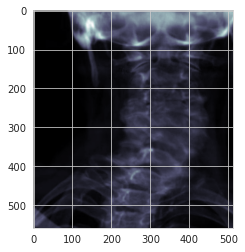

In [123]:
coronal_img = Image.open(os.path.join(XRAY_IMAGES_DIR, patient_id, "coronal.jpeg"))
coronal_img = np.asarray(coronal_img) / 255
plt.imshow(coronal_img, cmap='bone')
plt.axvline(coronal_center)

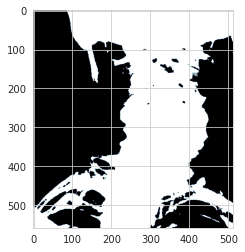

In [124]:
coronal = np.copy(coronal_img)
coronal[coronal < 0.1] = 0
coronal[coronal > 0] = 1
plt.imshow(coronal, cmap='bone')

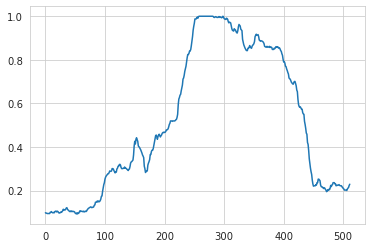

In [125]:
count_columns = np.mean(coronal, axis=0)
plt.plot(count_columns)
plt.show()

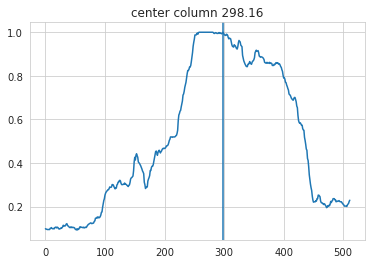

In [126]:
center_column = np.mean(np.argsort(count_columns)[-100:])

plt.plot(count_columns)
plt.axvline(center_column)
plt.title(f"center column {center_column}")
plt.show()

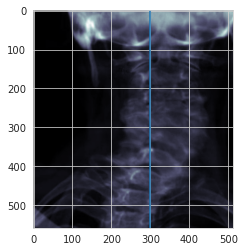

In [127]:
plt.imshow(coronal_img, cmap='bone')
plt.axvline(center_column)
plt.show()

So the final method is "find_coronal_center"

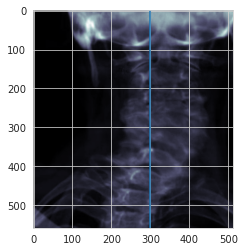

In [128]:

center_column, coronal_img = find_coronal_center(patient_id, XRAY_IMAGES_DIR)
plt.imshow(coronal_img, cmap='bone')
plt.axvline(center_column)
plt.show()

## Find slice top line

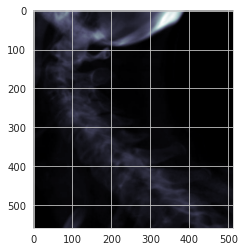

In [129]:
sagittal = Image.open(os.path.join(XRAY_IMAGES_DIR, patient_id, "sagittal.jpeg"))
sagittal = np.asarray(sagittal) / 255
plt.imshow(sagittal, cmap='bone')

10 x 10 mean pooling

torch.Size([559, 513])


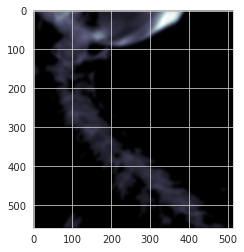

In [130]:
sagittal_tensor = torch.tensor(sagittal)
sagittal_tensor[sagittal_tensor < 0.1] = 0
sagittal_tensor = sagittal_tensor.reshape(1, 1, *sagittal_tensor.shape)
pool_out = F.avg_pool2d(sagittal_tensor, kernel_size=(10, 10), stride=1, padding=(5, 5)).squeeze()
print(pool_out.shape)
plt.imshow(pool_out, cmap='bone')

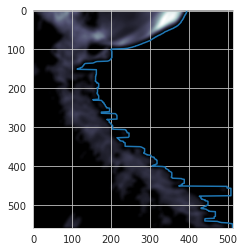

In [131]:
nonzero_indices = pool_out.nonzero()
max_columns = np.zeros(pool_out.shape[0])
for i in range(nonzero_indices.shape[0]):
    row, column = nonzero_indices[i]
    max_columns[row] = column

plt.imshow(pool_out, cmap='bone')
plt.plot(max_columns, np.arange(len(max_columns)))
plt.xlim(xmin=0)
plt.show()


아래위를 스무스하게 하고 가장 작은 점을 취한다.
이것을 기반으로 척추 위치를 정한다.

In [132]:
patient_df = xray_df.loc[patient_id].iloc[1]
patient_df

direction          1.000000
z_spacing          0.400024
pixel_spacing      0.265625
aspect             1.505973
width            512.000000
height           558.000000
Name: 1.2.826.0.1.3680043.575, dtype: float64

In [133]:
aspect = patient_df.aspect
aspect

1.5059727058823602

In [134]:
pixel_spacing = patient_df.pixel_spacing
pixel_spacing

0.265625

In [135]:
z_spacing = patient_df.z_spacing
z_spacing

0.4000240000000019

In [148]:
z_flip = patient_dcm_df.iloc[0].ImagePositionPatientZ - patient_dcm_df.iloc[1].ImagePositionPatientZ
z_flip = z_flip < 0
z_flip

True

In [157]:
slice_list = list(patient_dcm_df.InstanceNumber.values)
slice_list

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [136]:
min_slice = max_columns.argmin()

min_slice = int(np.round(min_slice / aspect))
min_slice

100

In [63]:
min_bottom = int(max_columns.min())
min_bottom

178

In [ ]:
if z_flip == True:
    num_instance = slice_list[-min_slice-1]
else:
    num_instance = slice_list[min_slice]

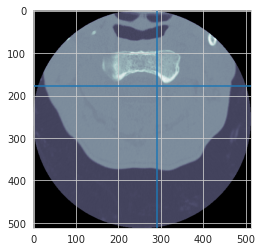

In [52]:
slice_img = read_dcm(os.path.join(TRAIN_IMAGES_DIR, patient_id), num_instance)
plt.imshow(slice_img, cmap='bone')
plt.axhline(min_bottom)
plt.axvline(center_column)
plt.show()

회색 부분이 value = 0.52 좌우

coronal center 에서 좌우로 50mm 정도만 취한다. 사실 더 작게 취하는것이 좋을것 같다.

In [66]:
width_pixel = int(np.round(50 / pixel_spacing))
width_pixel

197

In [67]:
int(center_column - width_pixel // 2)

193

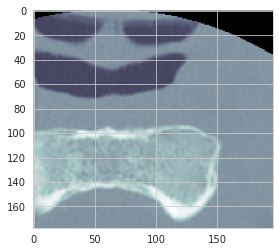

In [70]:
top_image = slice_img[:min_bottom, int(center_column - width_pixel // 2):int(center_column + width_pixel // 2)]
plt.imshow(top_image, cmap='bone')

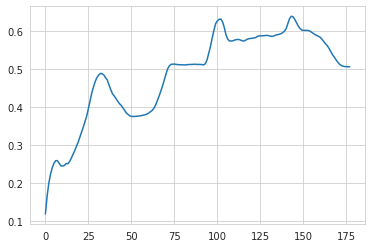

In [73]:
top_mean = top_image.mean(axis=1)
plt.plot(top_mean)

여기서 이 위치가 엄청 중요하다.
이 위치를 따라서 아래위로 척추의 위치를 그리게 된다.

94


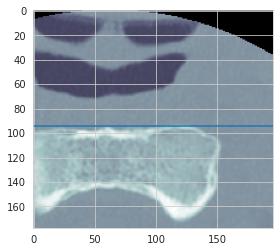

In [79]:
top_mean[top_mean < 0.52] = 0
min_top = top_mean.nonzero()[0][0]
print(min_top)
plt.imshow(top_image, cmap='bone')
plt.axhline(min_top)
plt.show()

이게 뼈가 차지하는 두께다.

In [83]:
height_pixel = min_bottom - min_top
height_pixel

84

In [84]:
height_mm = height_pixel * pixel_spacing
height_mm

21.328104000000003

### Final slice top function
결과적으로 find_sagittal_top 이라는 function 을 만들었다.

slice_top 16, aspect 1.5059727058823602 pixel spacing 0.265625 slice idx 100


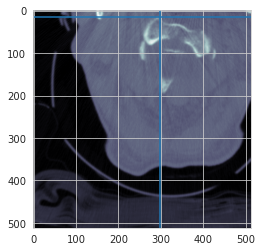

In [172]:
from utils.xray_utils import find_sagittal_top

patient_id = "1.2.826.0.1.3680043.575"
patient_df = xray_df.loc[patient_id].iloc[1]
slice_top, slice_idx, slice_img = find_sagittal_top(patient_id, XRAY_IMAGES_DIR, TRAIN_IMAGES_DIR, patient_df.aspect, patient_df.pixel_spacing, z_flip, slice_list, threshold=0.1)
print(f"slice_top {slice_top}, aspect {patient_df.aspect} pixel spacing {patient_df.pixel_spacing} slice idx {slice_idx}")
plt.imshow(slice_img, cmap='bone')
plt.axhline(slice_top)
plt.axvline(center_column)
plt.show()

max_width

In [167]:
max_width = 120 # 120 mm
max_width = int(max_width / pixel_spacing)
max_width

451

center 다시 찾기

In [171]:
max_height = 150 # 120 mm
max_height = min(512, int(max_height / pixel_spacing))
max_height

512

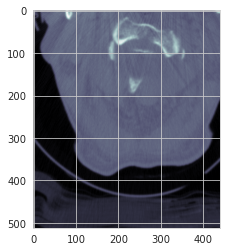

In [169]:
center_range = slice_img[slice_top:, int(center_column - max_width / 2): int(center_column + max_width / 2)]
plt.imshow(center_range, cmap='bone')

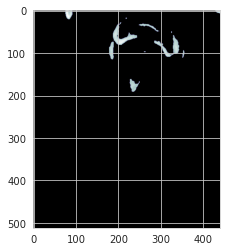

In [174]:
center_range[center_range < 0.6] = 0
plt.imshow(center_range, cmap='bone')

그 아래 slice 를 보자

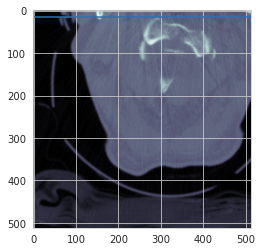

In [160]:
next_slice_idx = slice_idx + 1
next_slice_img = read_dcm(os.path.join(TRAIN_IMAGES_DIR, patient_id), next_slice_idx)
plt.imshow(slice_img, cmap='bone')
plt.axhline(slice_top)
plt.show()

어떤 한개 수치 top_range = constant (10mm) * z_spacing 를 계산할 영역으로 한다.
top_range px 만큼만 영역에서 변두리가 있는가 확인한다.

In [161]:
z_distance = 2
top_range = z_spacing / pixel_spacing * z_distance
top_range = int(np.ceil(top_range))
print(f"check range {top_range} px")

check range 4 px
